In [1]:
#import numpy as np
#import matplotlib.pyplot as plt
import os
from acoustics.signal import EqualBand, OctaveBand, Signal, Spectrum
from acoustics.building_acoustics_measurement import BuildingAcousticsMeasurement
from __future__ import division
%pylab

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_immediate_subdirectories(root_directory):
    return [name for name in os.listdir(root_directory) if os.path.isdir(os.path.join(root_directory, name))]

In [24]:
def illustrate_defects(measurement_folder, fs):
    def load_data(file_name):
        _, file_extension = os.path.splitext(file_name)
                
        if file_extension == '.CSV':
            data_s = np.loadtxt(file_name, delimiter=';', dtype=np.str)
            data = np.asarray(data_s[:, 0], dtype=np.float16)
        elif file_extension == '.npy':
            data = np.load(file_name)
        return data
    
    data_folders = get_immediate_subdirectories(measurement_folder)
    building_acoustics_measurement = BuildingAcousticsMeasurement(fs=fs, f_start=100, f_stop=5000, fraction=12)

    s = Spectrum()
    l = 100
    h = fs * 6

    for foo in data_folders:
        files = os.listdir(measurement_folder + foo)
        for f in files:
            data = None
            file_name = measurement_folder + foo + '/' + f
            
            if foo == 'background':
                pass

            elif foo == 'source':
                data = load_data(file_name)
                building_acoustics_measurement.compute_spl('tx', data[l:h])

            elif foo == 'receiving':
                data = load_data(file_name)
                building_acoustics_measurement.compute_spl('rx', data[l:h])
                
    freq = building_acoustics_measurement.octave_bands
    
    L1 = building_acoustics_measurement.tx_room_spl
    L2 = building_acoustics_measurement.rx_room_spl
    
    scale = 'log'
    title = ''
    x_label = 'Frequency - [Hz]'
    y_label = 'Sound Pressure Level - [dB]'
    legend = ['Source room', 'Receiving room']
    octave_tick = np.asarray(freq, dtype=np.int)[::5]
    Spreads = None

    plot_data([L1, L2], freq, title, y_label, x_label, legend, scale, True, False, Spreads, octave_tick)

In [25]:
folder = '../../data/DiagnosisTest/wall/'
fs = 11000
illustrate_defects(folder, fs)

In [26]:
folder = '../../data/DiagnosisTest/leak/'
fs = 11000
illustrate_defects(folder, fs)

In [14]:
def process_data(measurement_folder, fs):
    data_folders = get_immediate_subdirectories(measurement_folder)
    building_acoustics_measurement = BuildingAcousticsMeasurement(fs=fs, f_start=100, f_stop=5000, fraction=3)

    s = Spectrum()

    L1 = 0
    L2 = 0
    N = 0
    freq = 0
    
    L1_list = list()
    L2_list = list()
    N_list = list()

    count_n = 0
    count_l1 = 0
    count_l2 = 0

    for foo in data_folders:
        files = os.listdir(measurement_folder + foo)
        for f in files:
            file_name = measurement_folder + foo + '/' + f
            _, file_extension = os.path.splitext(file_name)
            data = None
            if file_extension == '.CSV':
                data_s = np.loadtxt(file_name, delimiter=';', dtype=np.str)
                data = np.asarray(data_s[:, 0], dtype=np.float16)
            elif file_extension == '.npy':
                data = np.load(file_name)
                
            if foo == 'background':
                pass

            elif foo == 'source':
                building_acoustics_measurement.compute_spl('tx', data)
                #freq, _, L1_temp = s.fractional_octaves(data, fs, start=100., stop=5000., fraction=12)
                #L1_list.append(L1_temp)
                #L1 = 10 * np.log10((10**(L1/10)) + (10**(L1_temp/10)))
                #count_l1 = count_l1 + 1

            elif foo == 'receiving':
                building_acoustics_measurement.compute_spl('rx', data)
                #freq, _, L2_temp = s.fractional_octaves(data, fs, start=100., stop=5000., fraction=12)
                #L2_list.append(L2_temp)
                #L2 = 10 * np.log10((10**(L2/10)) + (10**(L2_temp/10)))
                #count_l2 = count_l2 + 1
                
    freq = building_acoustics_measurement.octave_bands
    
    L1 = building_acoustics_measurement.tx_room_spl
    L2 = building_acoustics_measurement.rx_room_spl
    
    D_nT = building_acoustics_measurement.DnT()
    D_nT_w, ref_curve = building_acoustics_measurement.compute_single_number(D_nT)
    
    R = building_acoustics_measurement.R(20, 100) # 4m * 5m * 5m room
    R_w, ref_curve = building_acoustics_measurement.compute_single_number(R)
    
    '''RR = ref_curve - R
    RR = np.clip(RR, 0, RR.max())
    rr = 10**(RR/10)

    #plt.figure()
    #plt.plot(freq, RR[-1])
    plt.figure()
    
    plt.plot(freq, R)
    plt.xscale('log')
    plt.plot(freq, ref_curve[-1])
    plt.plot(freq, RR[-1])
    plt.axis()
    plt.show()
    
    plt.figure()
    plt.xscale('log')
    plt.plot(freq, rr[-1]/rr.max())
    plt.axis()
    plt.show()'''
        
    print("The single number R_w is : {0}").format(R_w)
    return freq, L1, L2, R, ref_curve[-1]

def plot_data(y_data, x_data=None, title=None, y_label=None, x_label=None, legend=None, scale='linear', multi_plot=False,\
              spread_plot=False, Spreads=None, args=None):
    colors = ['b', 'g']
    fig, ax = plt.subplots()
    if x_data is None:
        if multi_plot:
            for yy in y_data:
                ax.plot(yy)
    else:
        if multi_plot:
            for ii in xrange(len(y_data)):
                c = np.random.rand(3,1)
                ax.plot(x_data, y_data[ii], label=legend[ii])
                if spread_plot:
                    ax.plot(x_data, Spreads[ii], color=colors[ii], alpha=0.4)
                    #ax.fill_between(x_data, Spreads[ii][0], Spreads[ii][1], color=colors[ii], alpha=0.4, label='Spread')
        else:
            ax.plot(x_data, y_data)
    ax.set_xscale(scale)
    if args is not None:
        ax.set_xticks(args)
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend()
    ax.grid()
    #file_name = result_dir + title
    #fig.savefig(file_name)

In [13]:
## Wall
folder = '../../data/DiagnosisTest/wall/'
fs = 11000
freq, L1, L2, R, ref_curve = process_data(folder, fs)

scale = 'log'
title = 'Wall'
x_label = 'Frequency - [Hz]'
y_label = 'Sound Pressure Level - [dB]'
legend = ['Source room', 'Receiving room']
octave_tick = np.asarray(freq, dtype=np.int)[::7]
Spreads = None

plot_data([L1, L2], freq, title, y_label, x_label, legend, scale, True, False, Spreads, octave_tick)


## Door

folder = '../../data/DiagnosisTest/leak/'
fs = 11000
freq, L1, L2, R, ref_curve = process_data(folder, fs)

scale = 'log'
title = 'Door'
x_label = 'Frequency - [Hz]'
y_label = 'Sound Pressure Level - [dB]'
legend = ['Source room', 'Receiving room']
octave_tick = np.asarray(freq, dtype=np.int)[::7]
Spreads = None

plot_data([L1, L2], freq, title, y_label, x_label, legend, scale, True, False, Spreads, octave_tick)

The single number R_w is : 18
The single number R_w is : 18


In [8]:
legend = ['Source room', 'Receiving room']
octave_tick = np.asarray(freq, dtype=np.int)[::7]
Spreads = None

plot_data([L1, L2], freq, title, y_label, x_label, legend, scale, True, False, Spreads, octave_tick)

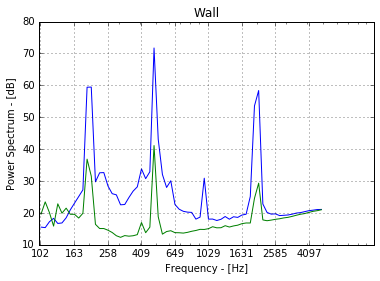

In [69]:
folder = '../../data/DiagnosisTest/wall/'
fs = 11000
freq, L1, L2, N, L1_list, L2_list, N_list = process_data(folder, fs)

scale = 'log'
title = 'Wall'
x_label = 'Frequency - [Hz]'
y_label = 'Sound Pressure Level - [dB]'
octave_tick = np.asarray(freq, dtype=np.int)[::8]

L1_a = np.asarray(L1_list)
L1_min = L1_a.min(axis=0)
L1_max = L1_a.max(axis=0)

L2_a = np.asarray(L2_list)
L2_min = L2_a.min(axis=0)
L2_max = L2_a.max(axis=0)

Spreads = [L1_a.T, L2_a.T]

plot_data([L1, L2], freq, title, y_label, x_label, scale, True, False, Spreads, octave_tick)

In [11]:
plt.plot(L1, label=None)
plt.plot(L2, label='test2')
plt.legend()
plt.show()

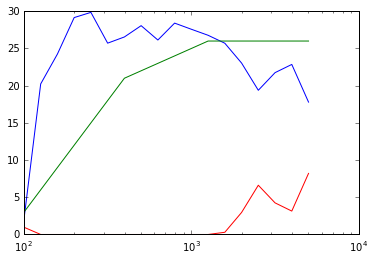

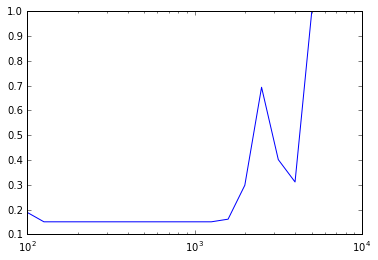

The single number R_w is : 22


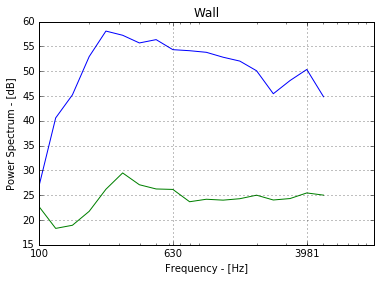

In [19]:
folder = '../../data/DasylabTests/AirLeakage01/'
fs = 20000

freq, L1, L2, R, ref_curve = process_data(folder, fs)

scale = 'log'
title = 'Wall'
x_label = 'Frequency - [Hz]'
y_label = 'Power Spectrum - [dB]'
octave_tick = np.asarray(freq, dtype=np.int)[::8]
Spreads = None

plot_data([L1, L2], freq, title, y_label, x_label, scale, True, False, Spreads, octave_tick)

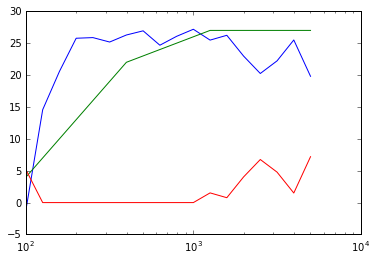

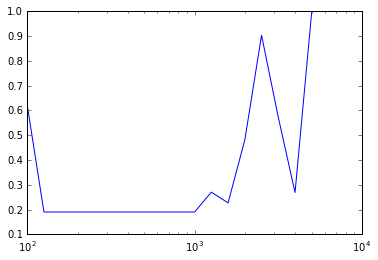

The single number R_w is : 23


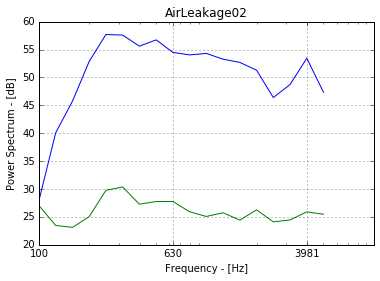

In [22]:
folder = '../../data/DasylabTests/AirLeakage02/'
fs = 20000

freq, L1, L2, R, ref_curve = process_data(folder, fs)

scale = 'log'
title = 'AirLeakage02'
x_label = 'Frequency - [Hz]'
y_label = 'Power Spectrum - [dB]'
octave_tick = np.asarray(freq, dtype=np.int)[::8]

plot_data([L1, L2], freq, title, y_label, x_label, scale, True, False, Spreads, octave_tick)

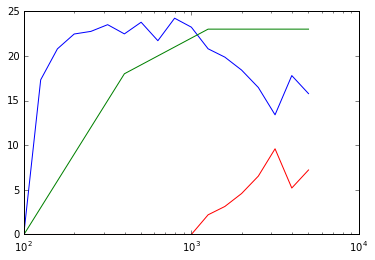

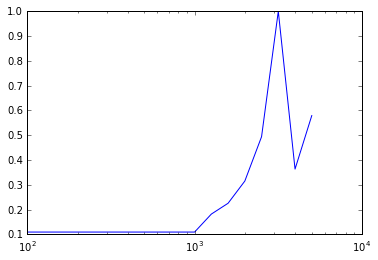

The single number R_w is : 19


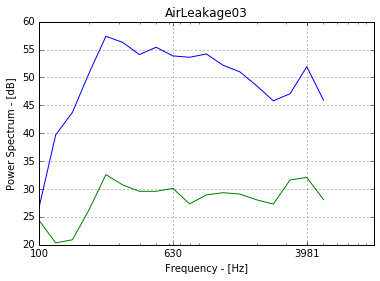

In [23]:
folder = '../../data/DasylabTests/AirLeakage03/'
fs = 20000

freq, L1, L2, R, ref_curve = process_data(folder, fs)

scale = 'log'
title = 'AirLeakage03'
x_label = 'Frequency - [Hz]'
y_label = 'Power Spectrum - [dB]'
octave_tick = np.asarray(freq, dtype=np.int)[::8]

plot_data([L1, L2], freq, title, y_label, x_label, scale, True, False, Spreads, octave_tick)

In [43]:
folder = '../../data/DasylabTests/WallDefect01/'
fs = 20000

freq, L1, L2, R, ref_curve = process_data(folder, fs)

scale = 'log'
title = 'WallDeect01'
x_label = 'Frequency - [Hz]'
y_label = 'Sound Pressure Level - [dB]'
octave_tick = np.asarray(freq, dtype=np.int)[::2]
legend = ['R`', 'Ref. curve']

plot_data([R, ref_curve], freq, title, y_label, x_label, legend, scale, True, False, Spreads, octave_tick)

The single number R_w is : 22


In [40]:
meas_folder = '../../data/DasylabTests/AirLeakage02/'
fs = 44100

freq, L1, L2, N = process_data(meas_folder)

scale = 'log'
title = 'AirLeakage02'
x_label = 'Frequency - [Hz]'
y_label = 'Power Spectrum - [dB]'
octave_tick = np.asarray(freq, dtype=np.int)[::8]

plot_data([L1, L2], freq, title, y_label, x_label, scale, True, octave_tick)

TypeError: process_data() takes exactly 2 arguments (1 given)

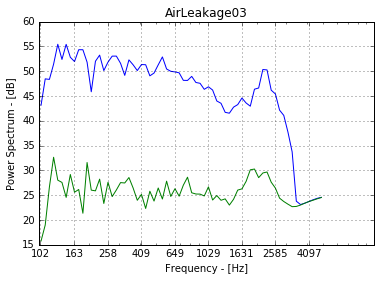

In [62]:
meas_folder = '../../data/DasylabTests/AirLeakage03/'
fs = 44100

freq, L1, L2, N = process_data(meas_folder, fs)

scale = 'log'
title = 'AirLeakage03'
x_label = 'Frequency - [Hz]'
y_label = 'Power Spectrum - [dB]'
octave_tick = np.asarray(freq, dtype=np.int)[::8]

plot_data([L1, L2], freq, title, y_label, x_label, scale, True, octave_tick)

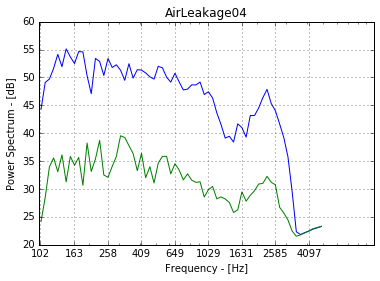

In [63]:
meas_folder = '../../data/DasylabTests/AirLeakage04/'
fs = 44100

freq, L1, L2, N = process_data(meas_folder, fs)

scale = 'log'
title = 'AirLeakage04'
x_label = 'Frequency - [Hz]'
y_label = 'Power Spectrum - [dB]'
octave_tick = np.asarray(freq, dtype=np.int)[::8]

plot_data([L1, L2], freq, title, y_label, x_label, scale, True, octave_tick)

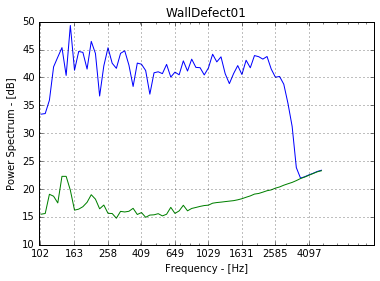

In [64]:
meas_folder = '../../data/DasylabTests/WallDefect01//'
fs = 44100

freq, L1, L2, N = process_data(meas_folder, fs)

scale = 'log'
title = 'WallDefect01'
x_label = 'Frequency - [Hz]'
y_label = 'Power Spectrum - [dB]'
octave_tick = np.asarray(freq, dtype=np.int)[::8]

plot_data([L1, L2], freq, title, y_label, x_label, scale, True, octave_tick)

In [ ]:
plt.figure()
rx_data = np.load('../../data/DasylabTests/AirLeakage01/Measurement-1-rx.npy')
rx_spectra = abs(np.fft.rfft(rx_data))
plt.plot(rx_spectra)
rx_data = np.load('../../data/DasylabTests/AirLeakage01/Measurement-2-rx.npy')
rx_spectra = abs(np.fft.rfft(rx_data))
plt.plot(rx_spectra)
rx_data = np.load('../../data/DasylabTests/AirLeakage01/Measurement-3-rx.npy')
rx_spectra = abs(np.fft.rfft(rx_data))
plt.plot(rx_spectra)

plt.figure()
tx_data = np.load('../../data/DasylabTests/AirLeakage01/Measurement-4-tx.npy')
tx_spectra = abs(np.fft.rfft(tx_data))
plt.plot(tx_spectra)
tx_data = np.load('../../data/DasylabTests/AirLeakage01/Measurement-5-tx.npy')
tx_spectra = abs(np.fft.rfft(tx_data))
plt.plot(tx_spectra)
tx_data = np.load('../../data/DasylabTests/AirLeakage01/Measurement-6-tx.npy')
tx_spectra = abs(np.fft.rfft(tx_data))
plt.plot(tx_spectra)

plt.show()

In [17]:
s = Spectrum()

tx_t = np.load('../../data/DasylabTests/WallDefect01//Measurement-1-tx.npy')
f, tx_f, tx_f_db = s.fractional_octaves(tx_t, fs, start=100., stop=10000., fraction=12)

rx_t = np.load('../../data/DasylabTests/WallDefect01//Measurement-4-rx.npy')
f, rx_f, rx_f_db = s.fractional_octaves(rx_t, fs, start=100., stop=10000., fraction=12)

tl = tx_f_db - rx_f_db

In [18]:
plt.figure()
plt.title("Tx")
plt.plot(f.center, tx_f_db)
plt.grid()

plt.figure()
plt.title("Rx")
plt.plot(f.center, rx_f_db)
plt.grid()

plt.figure()
plt.title("Tranmission Loss")
plt.plot(f.center, tl)
plt.grid()

plt.show()

In [43]:
speaker_response = np.load('../../data/DasylabTests/SpeakerResponse/Measurement-1-tx.npy')
speaker_response_f = abs(np.fft.rfft(speaker_response))
freq = np.fft.fftfreq(speaker_response.size, 1/fs)[:(speaker_response_f.size-1)]
plt.figure()
plt.plot(freq, speaker_response_f[:-1])
plt.show()

In [42]:
freq[0]

0.0

In [24]:
s = Spectrum()
file_name = '../../data/DiagnosisTest/leak/source/'
fs = 11000

d = np.loadtxt(file_name, delimiter=';', dtype=np.str)
data = np.asarray(d[:, 0], dtype=np.float16)

freq, power_spectrum, power_spectrum_db = s.fractional_octaves(data, fs, start=100., stop=5000., fraction=3)

In [25]:
plt.figure()
plt.plot(data)

plt.figure()
plt.plot(freq.center, power_spectrum/power_spectrum.max())

plt.figure()
plt.plot(freq.center, power_spectrum_db)

plt.show()

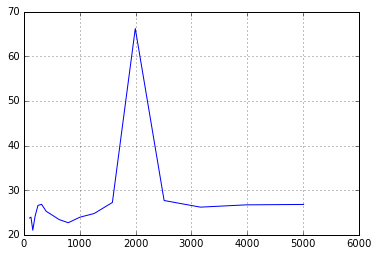

In [37]:
file_name = '../../data/DiagnosisTest/leak/source/15_1.CSV'
data_s = np.loadtxt(file_name, delimiter=';', dtype=np.str)
data = np.asarray(data_s[:, 0], dtype=np.float16)
freq, power_spectrum, power_spectrum_db = s.fractional_octaves(data, fs, start=100., stop=5000., fraction=3)
plt.plot(freq.center, power_spectrum_db)
plt.grid()
plt.show()

In [2]:
from acoustics.generator import Generator
from scipy.signal import fftconvolve
%pylab

fs = 20000.
duration = 1.
gen = Generator(fs, duration)
sine_sweep, inverse_signal = gen.noise('sine_sweep', [10., 100.])
impulse = fftconvolve(sine_sweep, inverse_signal)

t = np.arange(sine_sweep.size) / fs

plot_data(sine_sweep, x_data=t, title='', y_label='Amplitude', x_label='Time [sec]')
plot_data(inverse_signal, x_data=t, title='', y_label='Amplitude', x_label='Time [sec]')
plot_data(impulse, x_data=(np.arange(impulse.size)/fs), title='', y_label='Amplitude', x_label='Time [sec]')

'''plt.figure()
plt.plot(t, sine_sweep, c='c0')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')

plt.figure()
plt.plot(t, inverse_signal, c='c0')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')


plt.figure()
plt.plot((np.arange(impulse.size)/fs), impulse, c='c0')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')

plt.show()'''

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


C:\Users\sengan\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


"plt.figure()\nplt.plot(t, sine_sweep, c='c0')\nplt.xlabel('Time [sec]')\nplt.ylabel('Amplitude')\n\nplt.figure()\nplt.plot(t, inverse_signal, c='c0')\nplt.xlabel('Time [sec]')\nplt.ylabel('Amplitude')\n\n\nplt.figure()\nplt.plot((np.arange(impulse.size)/fs), impulse, c='c0')\nplt.xlabel('Time [sec]')\nplt.ylabel('Amplitude')\n\nplt.show()"

In [30]:
# Without lamp
# source
pos_1 = np.array([95.7, 103.2, 103.8, 104.8, 102.6, 101.3, 98.6, 98.6, 97.2, 96.4, 94.3, 93.0, 94.8, 94.9, 93.2, 91.4])
pos_2 = np.array([90.9, 103.6, 102.0, 103.2, 97.4, 98.9, 98.5, 96.9, 96.5, 95.3, 93.0, 92.5, 94.5, 94.8, 94.0, 91.4])
pos_3 = np.array([95.9, 105.7, 104.3, 104.9, 100.2, 99.7, 98.4, 96.8, 96.3, 94.4, 93.5, 92.5, 94.8, 94.4, 94.0, 92.6])
pos_4 = np.array([91.7, 97.5, 102.8, 102.5, 101.4, 98.7, 98.4, 98.9, 95.8, 94.7, 94.3, 92.9, 94.7, 95.1, 92.9, 93.0])
pos_5 = np.array([92.7, 99.8, 106.8, 103.1, 103.0, 101.7, 97.0, 97.2, 97.1, 95.5, 94.4, 92.1, 95.5, 95.3, 93.9, 92.5])

# receiver
pos_1 = np.array([41.6, 48.6, 52.4, 47.7, 42.7, 40.1, 39.7, 35.4, 40.3, 31.1, 26.0, 25.3, 19.9, 25.1, 27.3, 27.7])
pos_2 = np.array([42.8, 53.4, 53.2, 47.9, 44.0, 38.6, 37.4, 34.9, 38.9, 29.9, 24.9, 24.6, 19.9, 25.0, 27.9, 27.5])
pos_3 = np.array([43.6, 55.4, 55.2, 48.8, 43.4, 39.1, 39.0, 35.2, 39.3, 32.5, 25.9, 25.6, 21.4, 25.8, 28.4, 28.6])
pos_4 = np.array([43.2, 52.4, 51.4, 45.9, 44.3, 39.2, 39.6, 34.8, 39.9, 31.0, 25.1, 26.2, 19.9, 24.3, 26.7, 27.2])
pos_5 = np.array([43.3, 53.7, 54.4, 47.7, 42.4, 39.5, 37.8, 33.7, 37.8, 29.8, 26.0, 25.1, 19.7, 24.9, 27.4, 27.3])


# With lamp
# source
pos_1 = np.array([96.4, 101.3, 105.4, 100.5, 105.1, 103.1, 99.2, 98.3, 96.5, 96.3, 94.4, 92.0, 94.7, 94.3, 93.6, 91.6])
pos_2 = np.array([95.6, 101.1, 106.4, 98.6, 101.4, 101.5, 99.4, 97.2, 95.6, 95.7, 94.7, 93.4, 95.3, 94.6, 93.5, 91.6])
pos_3 = np.array([99.3, 101.5, 109.6, 101.8, 101.2, 102.6, 99.6, 98.6, 97.2, 96.5, 93.3, 93.3, 94.2, 94.9, 93.1, 92.3])
pos_4 = np.array([97.6, 98.0, 107.5, 100.6, 100.7, 99.9, 99.0, 96.9, 96.3, 95.3, 93.6, 92.8, 96.1, 95.0, 93.9, 92.3])
pos_5 = np.array([97.8, 98.7, 104.8, 101.0, 100.2, 99.1, 98.0, 97.4, 94.7, 94.6, 92.9, 92.4, 95.3, 94.7, 93.4, 92.0])

# receiver
pos_1 = np.array([48.2, 53.1, 52,4, 43.5, 41.1, 39.4, 37.4, 33.3, 29.7, 24.9, 25.1, 20.1, 17.7, 19.9, 18.4, 21.8])
pos_2 = np.array([47.6, 51.3, 51.5, 46.4, 47.1, 38.7, 37.9, 32.1, 29.8, 24.9, 24.8, 19.8, 17.8, 18.4, 20.0, 20.6])
pos_3 = np.array([45.3, 50.7, 53.6, 45.2, 41.4, 39.5, 37.5, 32.5, 28.8, 24.9, 25.7, 19.5, 17.8, 19.5, 19.5, 21.5])
pos_4 = np.array([46.0, 51.5, 53.9, 45.6, 41.8, 40.1, 38.8, 32.2, 30.3, 25.9, 24.3, 20.0, 18.1, 18.8, 19.6, 21.3])
pos_5 = np.array([46.1, 52.6, 55.3, 43.4, 39.2, 36.9, 39.2, 30.9, 29.7, 24.7, 24.3, 20.0, 17.9, 18.7, 20.5, 20.8])



# With concrete
# source
pos_1 = np.array([98.2, 103.9, 102.7, 103.2, 99.9, 98.6, 97.0, 96.6, 94.6, 94.9, 94.6, 92.9, 94.5, 94.5, 93.4, 92.1])
pos_2 = np.array([97.7, 104.2, 107.2, 104.2, 102.7, 102.9, 98.3, 99.0, 96.4, 96.5, 94.8, 93.2, 95.2, 94.4, 94.0, 93.0])
pos_3 = np.array([95.5, 102.0, 107.3, 103.4, 102.6, 103.1, 98.6, 98.3, 96.1, 97.0, 93.9, 93.3, 95.0, 94.7, 93.4, 91.7])
pos_4 = np.array([96.5, 101.1, 105.4, 103.4, 102.2, 101.6, 99.0, 95.8, 95.2, 95.7, 93.0, 91.9, 94.8, 95.0, 93.9, 92.2])
pos_5 = np.array([93.3, 100.6, 103.5, 103.4, 102.5, 99.1, 98.1, 98.0, 96.9, 95.9, 93.6, 92.1, 95.0, 95.3, 93.9, 92.7])


# receiver
pos_1 = np.array([42.5, 46.6, 51.7, 47.2, 43.6, 37.5, 36.5, 32.0, 29.8, 25.2, 25.4, 17.6, 15.8, 14.7, 14.0, 12.3])
pos_2 = np.array([42.1, 51.1, 52.4, 48.2, 43.8, 38.3, 38.0, 31.5, 29.5, 25.1, 26.5, 18.9, 15.9, 14.8, 14.0, 12.0])
pos_3 = np.array([41.7, 54.3, 53.6, 47.1, 44.3, 38.2, 37.3, 32.7, 28.9, 26.0, 24.3, 17.4, 16.4, 14.8, 14.1, 12.2])
pos_4 = np.array([43.5, 55.6, 55.0, 47.1, 42.5, 39.9, 37.8, 32.1, 28.2, 26.2, 25.8, 18.1, 15.4, 15.0, 15.0, 12.0])
pos_5 = np.array([42.9, 49.7, 49.8, 47.6, 43.1, 38.8, 37.1, 31.8, 28.5, 26.1, 24.6, 17.8, 15.6, 14.0, 14.6, 12.5])



# Reverberation chamber RT60 : T30
pos_1 = np.array([7.65, 6.48, 6.20, 7.64, 6.58, 6.15, 5.93, 6.37, 6.17, 6.23, 5.82, 5.46, 5.45, 5.01, 4.40, 3.68])
pos_2 = np.array([8.87, 5.79, 6.76, 7.21, 6.32, 6.33, 6.11, 6.35, 6.07, 5.84, 5.79, 5.55, 5.37, 5.09, 4.49, 3.65])
pos_3 = np.array([14.09, 7.28, 6.27, 7.30, 6.44, 5.97, 6.62, 5.71, 6.05, 5.99, 5.56, 5.65, 5.31, 4.95, 4.48, 3.76])
pos_4 = np.array([14.32, 6.50, 6.85, 7.82, 6.47, 5.28, 5.88, 5.51, 6.15, 5.67, 5.60, 5.56, 5.21, 4.96, 4.29, 3.61])
pos_5 = np.array([13.47, 6.33, 6.34, 8.13, 7.27, 6.13, 5.66, 5.95, 5.82, 6.02, 5.50, 5.41, 5.48, 5.03, 4.49, 3.67])

rt60_mean = np.array([11.372, 6.622, 6.485, 7.60, 6.678, 6.005, 5.985, 5.968, 6.047, 5.953, 5.632, 5.585, 5.348,
                      4.978, 4.417, 3.663])


# SPl test
pos_1 = np.array([94.8, 100.8, 106.4, 104.4, 104.7, 102.8, 100.3, 99.6, 98.2, 97.8, 95.2, 93.4, 94.5, 94.5, 93.5, 92.8])
pos_2 = np.array([94.4, 100.6, 105.4, 103.5, 104.5, 102.6, 100.2, 99.2, 97.9, 97.7, 94.9, 93.3, 94.1, 94.4, 93.5, 92.7])
pos_3 = np.array([94.0, 100.4, 105.7, 103.5, 104.4, 102.5, 99.8, 99.5, 97.9, 97.4, 95.0, 93.1, 94.3, 94.4, 93.7, 92.8])
pos_4 = np.array([94.0, 100.7, 105.3, 103.3, 104.4, 102.4, 100.0, 99.4, 98.1, 97.4, 94.8, 93.0, 94.1, 94.6, 93.6, 92.8])
pos_5 = np.array([94.7, 101.2, 105.4, 103.5, 104.6, 102.7, 99.8, 99.3, 98.0, 97.4, 94.7, 93.0, 94.3, 94.4, 93.6, 93.0])



In [28]:
octave_bands = np.array([100, 125, 160, 200, 250, 315, 400, 500, 630, 800, 1000, 1250, 1600, 2000, 2500, 3150])

plt.figure()
plt.plot(x, y_, c='tab:blue')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Sound Pressure Level [dB]')
plt.grid(linestyle='dotted')
plt.legend()

In [29]:
plt.legend()